## Introduction

<br />
This tutorial will go through the steps required to produce the Long Time Series Products (LTSPs).
<br />

<br />
<br />

Aim to create a mooring plotting "package" that produces plots for the automatic QAQC report, gets basic stats, outputs files useful for model comparisons.

<br />

*  LTSPs automatically created at time of QC reporting. 
*  We use the hourly LTSP as a starting point for the mooring figures.

<br />

Users: 

1.  Tim and Stuart (QC and reporting)
2.  Model validation
3.  Useful Python functions / plots for research

### Add packages

In [30]:
# change directory to aodntools where scripts are stored
import os
os.chdir('C:\\Users\\mphem\\Documents\\Work\\UNSW\\LTSP\\Code\\python-aodntools-master\\' +
          'python-aodntools-master\\')
# Velocity
import aodntools.timeseries_products.velocity_aggregated_timeseries as vat
import aodntools.timeseries_products.velocity_hourly_timeseries as vatrly
# Temp and others
import aodntools.timeseries_products.aggregated_timeseries as agg
import aodntools.timeseries_products.hourly_timeseries as hrly
import aodntools.timeseries_products.gridded_timeseries as grid
# get file list
# import geoserverCatalog as gc # not needed today as we are using files stored on the server
# other useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Create An Aggregated Data Product

![](slide_1.PNG)    

### Preparing for aggregation


#### Mount the IMOS KDM server

We need to access mooring files that are stored in a folder called 'sci-maths-ocean'. This folder is accessible within the KDM server but you will have to do a couple of steps to access.  

#### What I do (Windows):

1.  Open Windows PowerShell (Terminal), 
    login to KDM -> 'ssh zID@kdm.restech.unsw.edu.au' with password, 
    type 'network' and enter same password as z id. 
2.  Open SFTP Drive program, 
    mount KDM server (kdm.restech.unsw.edu.au). 
    I can now open the folder interactively.
    
troubleshooting:
    
Entering 'network' doesn't work? check with the administrator (Duncan Smith et al at maths IT, SCI Maths Helpdesk <helpdesk.mathsstats@unsw.edu.au>) as you may not have permission. Other errors when using 'network'? try 'network -u' first which should clear any residual mounts. You will occassionally have to type 'network' as sometimes the mounted folder opens but does not contain files. 
    
Files should be accessible without using the vpn. 
    
Mac users?
You can use the terminal program that is already available, and you can mount the 'sci-maths-ocean' folder directly using finder and option "Connect to Server" I believe. 
    
### Finding the files
    
![Logged in](logged_in.PNG)    

Go to Z:\home\z3526971\sci-maths-ocean\IMOS\DATA\MOORINGS\PROCESSED_2_5

![Logged in](sites.PNG)        
    
### Get a list of mooring files that we want to aggregate  

Let's choose PH100 temperature 
    

In [4]:
# Function to get file names

def get_files(mooring_dir,site_code,var,time_start,time_end):
    #######################################################################################
    # time_start   Use np.datetime64 or '' if no start limit
    # time_end   Use np.datetime64 or '' if no end limit
    #######################################################################################
    # Includes the files that has data within this range, but does not slice the file.
    # So aggregated product will not exactly have the input time range
    #######################################################################################
    path = mooring_dir + '\\' + site_code + '\\' + var + '\\' # need double '\'
    files = os.listdir(path)
    #######################################################################################
    # remove non-netCDF formats
    for n in range(len(files)):
        if '.nc' not in files[n]:
            files[n] = []
    files = [ele for ele in files if ele != []]
    #######################################################################################
    # remove files outside of time range
    if 'datetime64' in str(type(time_start)):
        for n in range(len(files)):
            ###############################################
            # get start and end date of file
            f = files[n]
            # Identify all underscores to get dates
            underscore_index = [nn for nn in range(len(f)) if f.find('_', nn) == nn]
            start_date = f[underscore_index[2]+1:underscore_index[3]-1]
            end_date = f[underscore_index[6]+5:underscore_index[7]-1]
            # convert to numpy datetime64
            start_date = np.datetime64(start_date[0:4] + '-' + start_date[4:6] 
                                       + '-' + start_date[6:8])
            end_date = np.datetime64(end_date[0:4] + '-' + end_date[4:6] 
                                       + '-' + end_date[6:8])
            ###############################################
            # if no input for time_start and time_end, get earliest date
            if '-' not in str(time_start):
                time_start = np.datetime64('2008-01-01')
            if '-' not in str(time_end):
                time_end = np.datetime64('2030-01-01')
            ###############################################
            # remove file if outside of the time range
            if start_date < time_start or end_date > time_end:
                files[n] = []
    
    files = [ele for ele in files if ele != []]
    return files, path

In [5]:
# Define site code and variable of interest
site_code = 'PH100'
var = 'TEMPERATURE'
time_start = np.datetime64('2021-01-01')
time_end = '' # if left as '' no end date limit
mooring_dir = 'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\'
# get file list
files, path = get_files(mooring_dir,site_code,var,time_start,time_end)
files[0:10]

['IMOS_ANMN-NSW_TZ_20210401T012500Z_PH100_FV01_PH100-2104-Aqualogger-AQUAlogger-520T-max1000m-56_END-20210615T020000Z_C-20210702T020211Z.nc',
 'IMOS_ANMN-NSW_TZ_20210111T005500Z_PH100_FV01_PH100-2101-Aqualogger-520T-80_END-20210331T234000Z_C-20210415T062122Z.nc',
 'IMOS_ANMN-NSW_TZ_20210615T024500Z_PH100_FV01_PH100-2106-Aqualogger-AQUAlogger-520PT16-max160m-104_END-20210901T004000Z_C-20210910T052028Z.nc',
 'IMOS_ANMN-NSW_TZ_20210401T012500Z_PH100_FV01_PH100-2104-Aqualogger-AQUAlogger-520PT16-max160m-104_END-20210615T020000Z_C-20210702T020209Z.nc',
 'IMOS_ANMN-NSW_TZ_20210111T005500Z_PH100_FV01_PH100-2101-Aqualogger-AQUAlogger-520PT16-max160m-104_END-20210331T234000Z_C-20210415T062121Z.nc',
 'IMOS_ANMN-NSW_TZ_20210111T005500Z_PH100_FV01_PH100-2101-Aqualogger-520T-56_END-20210331T234000Z_C-20210415T062123Z.nc',
 'IMOS_ANMN-NSW_TZ_20210901T005500Z_PH100_FV01_PH100-2109-Aqualogger-AQUAlogger-520T-max1000m-32_END-20211215T003500Z_C-20220224T011135Z.nc',
 'IMOS_ANMN-NSW_TZ_20210615T024500Z_P

In [6]:
len(files)

52

In [7]:
path

'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\\\PH100\\TEMPERATURE\\'

### Aggregate temperature files

In [11]:
agg.main_aggregator(files, 'TEMP', site_code, input_dir=path, 
                    output_dir='', download_url_prefix=None, opendap_url_prefix=None)

# NOTE: I kept getting errors for xarray dependencies, so I added 'engine='netcdf4' 
# on line 227 in 'aggregated_timeseries.py' and it worked

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mphem\\Documents\\Work\\UNSW\\LTSP\\Code\\python-aodntools-master\\python-aodntools-master\\tmp1hriic09.nc'

## -----------------------------------
## Ignore error, it works!
#### Related to temporary nc file. Not Agg data product.
## -----------------------------------

### Data Product Information

In [8]:
filename = 'IMOS_ANMN-NSW_TZ_20210111_PH100_FV01_TEMP-aggregated-timeseries_END-20211215_C-20220428.nc'
agg_data = xr.open_dataset(filename)

In [9]:
agg_data.info()

xarray.Dataset {
dimensions:
	OBSERVATION = 1235743 ;
	INSTRUMENT = 52 ;

variables:
	float32 TEMP(OBSERVATION) ;
		TEMP:ancillary_variables = TEMP_quality_control ;
		TEMP:long_name = sea_water_temperature ;
		TEMP:standard_name = sea_water_temperature ;
		TEMP:units = degrees_Celsius ;
		TEMP:valid_max = 40.0 ;
		TEMP:valid_min = -2.5 ;
	float32 TEMP_quality_control(OBSERVATION) ;
		TEMP_quality_control:flag_meanings = No_QC_performed Good_data Probably_good_data Bad_data_that_are_potentially_correctable Bad_data Value_changed Not_used Not_used Not_used Missing_value ;
		TEMP_quality_control:flag_values = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ;
		TEMP_quality_control:long_name = quality flag for sea_water_temperature ;
		TEMP_quality_control:standard_name = sea_water_temperature status_flag ;
	float32 DEPTH(OBSERVATION) ;
		DEPTH:ancillary_variables = DEPTH_quality_control ;
		DEPTH:long_name = actual depth ;
		DEPTH:positive = down ;
		DEPTH:reference_datum = sea surface ;
		DEPTH:standard_n

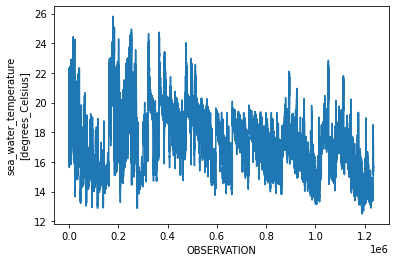

In [10]:
agg_data.TEMP.plot()

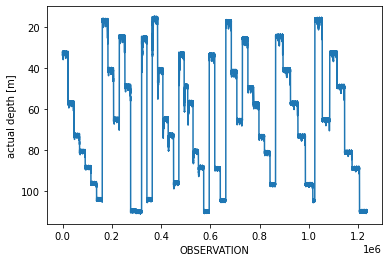

In [11]:
agg_data.DEPTH.plot()
plt.gca().invert_yaxis()

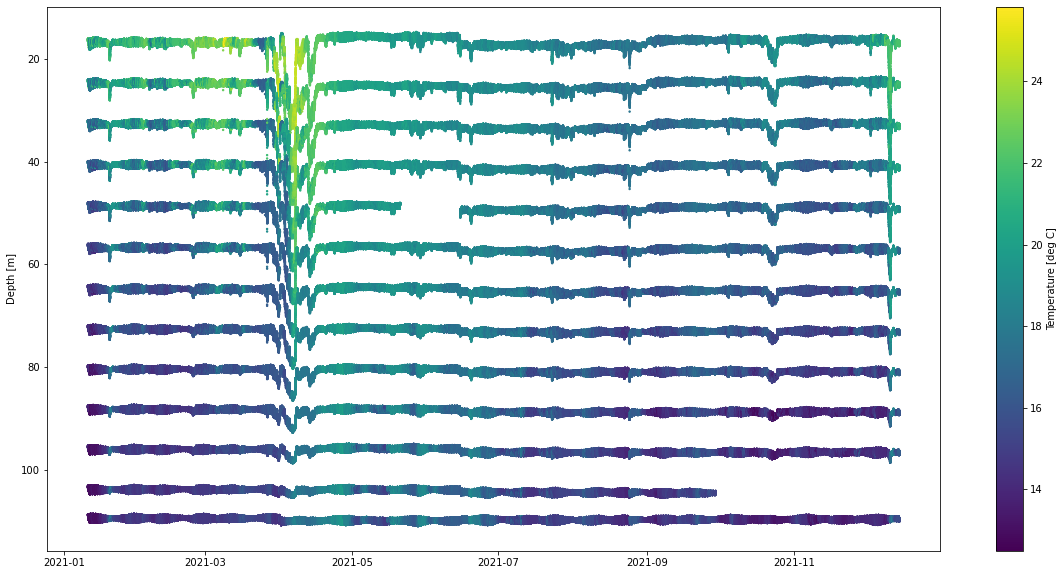

In [12]:
# %matplotlib qt
plt.figure(figsize=(20,10))
plt.scatter(agg_data.TIME,agg_data.DEPTH,c=agg_data.TEMP,s=2)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.colorbar(label='Temperature [deg C]')
# %matplotlib inline

 ## Create An Hourly Data Product
 
 ![](slide_2.PNG) 

In [16]:
qcflags = [1,2] # good data, probably good data


import warnings # to suppress the version warnings

with warnings.catch_warnings(record=True):
    hrly.hourly_aggregator(files, site_code, qcflags, input_dir=path, output_dir='./',
                          download_url_prefix=None, opendap_url_prefix=None)
"""
Aggregate a dataset into 1 hour intervals and calculate related statistics

:param files_to_aggregate: List of files to aggregate. Each path is interpreted relative
to input_dir (if specified). These paths are listed in the `source_files` variable in the output file.
:param site_code: code of the mooring site
:param qcflags: list of QCflags indicating what values of the variables to keep
:param input_dir: base path where source files are stored
:param output_dir: path where the result file will be written
:param download_url_prefix: URL prefix for file download (to be prepended to paths in files_to_aggregate)
:param opendap_url_prefix: URL prefix for OPENAP access (to be prepended to paths in files_to_aggregate)
:return: tuple (path of the output file, dict of rejected files and error messages)
"""

NameError: name 'pd' is not defined

In [18]:
filename = 'IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_hourly-timeseries_END-20211215_C-20220428.nc'
hrly_data = xr.open_dataset(filename)

In [19]:
hrly_data.info()

xarray.Dataset {
dimensions:
	OBSERVATION = 103031 ;
	INSTRUMENT = 52 ;

variables:
	int32 instrument_index(OBSERVATION) ;
		instrument_index:long_name = which instrument this obs is for ;
		instrument_index:instance_dimension = INSTRUMENT ;
	|S256 instrument_id(INSTRUMENT) ;
		instrument_id:long_name = source deployment code, instrument make, model, serial_number ;
	|S256 source_file(INSTRUMENT) ;
		source_file:long_name = source file for this instrument ;
	datetime64[ns] TIME(OBSERVATION) ;
		TIME:axis = T ;
		TIME:comment = time stamp corresponds to the hour and represents binned data [30,30) minutes before and after the hour ;
		TIME:long_name = time ;
		TIME:standard_name = time ;
		TIME:valid_max = 90000.0 ;
		TIME:valid_min = 0.0 ;
	float64 LONGITUDE(INSTRUMENT) ;
		LONGITUDE:axis = X ;
		LONGITUDE:long_name = longitude ;
		LONGITUDE:reference_datum = WGS84 geographic coordinate system ;
		LONGITUDE:standard_name = longitude ;
		LONGITUDE:units = degrees_east ;
		LONGITUDE:valid

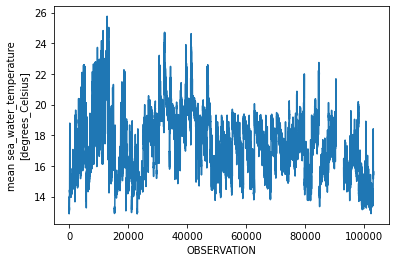

In [20]:
hrly_data.TEMP.plot()

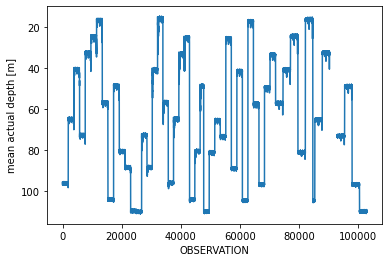

In [21]:
hrly_data.DEPTH.plot()
plt.gca().invert_yaxis()

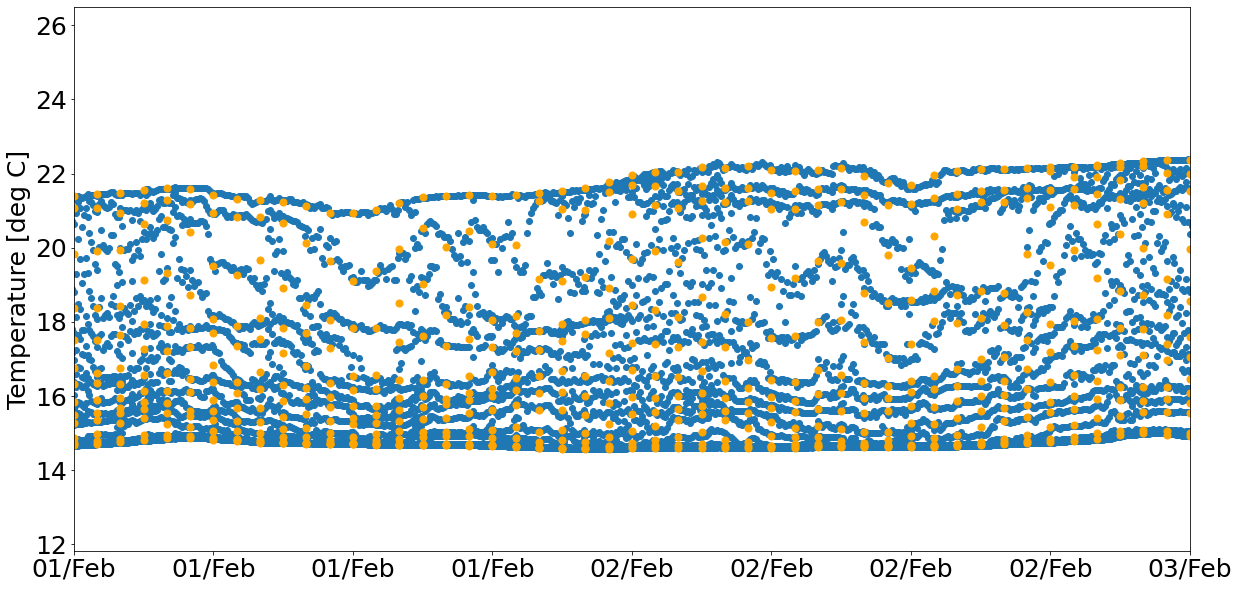

In [60]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(agg_data.TIME,agg_data.TEMP)
plt.scatter(hrly_data.TIME,hrly_data.TEMP,s=50,c='orange')
plt.xlim(left=np.datetime64('2021-02-01'),right=np.datetime64('2021-02-03'))
plt.ylabel('Temperature [deg C]')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%h'))
plt.rc('font', size=25)

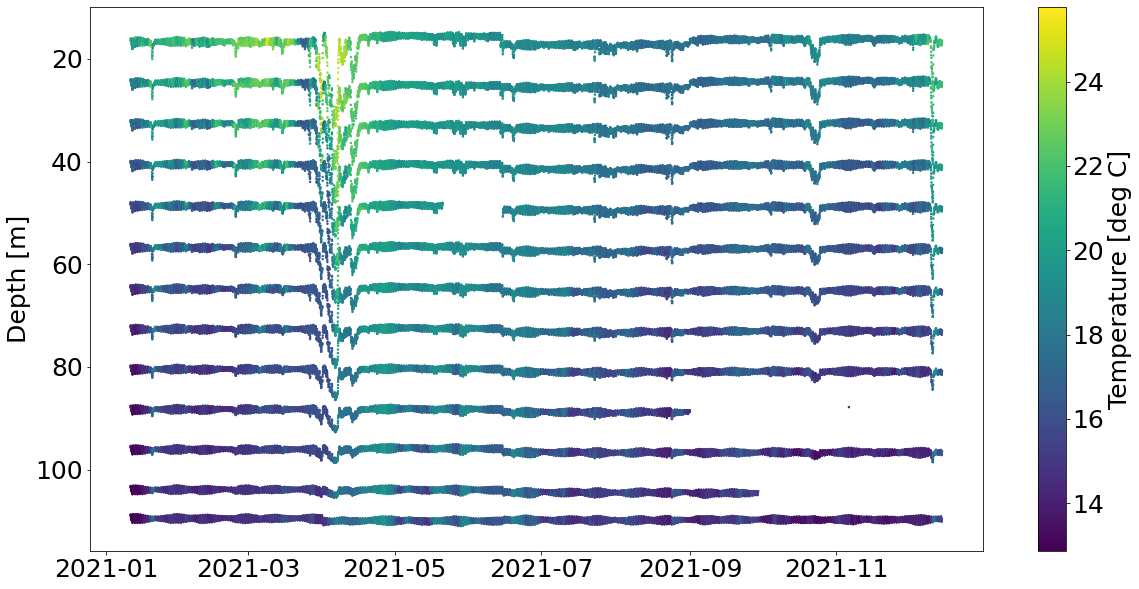

In [61]:
# %matplotlib qt
plt.figure(figsize=(20,10))
plt.scatter(hrly_data.TIME,hrly_data.DEPTH,c=hrly_data.TEMP,s=2)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.colorbar(label='Temperature [deg C]')
# %matplotlib inline

## Create a Gridded Data Product

![](slide_3.PNG)      

In [62]:
hourly_file = filename
filename

'IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_hourly-timeseries_END-20211215_C-20220428.nc'

In [64]:
grid.grid_variable(hourly_file, 'TEMP', depth_bins=None, max_separation=50, depth_bins_increment=1,
                  input_dir='', output_dir='.', download_url_prefix=None, opendap_url_prefix=None)
    
"""
Grid VoI into depth_bins.
:param input_file: Input hourly aggregated file with VoI, DEPTH and TIME only (path interpreted relative
to input_dir, if specified)
:param VoI: variable of interest (TEMP or PSAL)
:param depth_bins: list of depth where to interpolate. if null list is provided it will be calculated from the data
:param max_separation: max separation allowed for instruments
:param depth_bins_increment: in case no depth bins provided this is the increment for the calculated bins
:param input_dir: base path where source files are stored
:param output_dir: path where the result file will be written
:param download_url_prefix: URL prefix for file download (to be prepended to input_file path)
:param opendap_url_prefix: URL prefix for OPENAP access (to be prepended to input_file path)
:return: path of interpolated output file
"""    
    

C:\Users\mphem\Documents\Work\UNSW\LTSP\Code\python-aodntools-master\python-aodntools-master\aodntools\timeseries_products\gridded_timeseries.py:88: SerializationWarning: saving variable TEMP_count with floating point data as an integer dtype without any _FillValue to use for NaNs
  agg_dataset.to_netcdf(output_path, encoding=encoding, format='NETCDF4_CLASSIC')


'\nGrid VoI into depth_bins.\n:param input_file: Input hourly aggregated file with VoI, DEPTH and TIME only (path interpreted relative\nto input_dir, if specified)\n:param VoI: variable of interest (TEMP or PSAL)\n:param depth_bins: list of depth where to interpolate. if null list is provided it will be calculated from the data\n:param max_separation: max separation allowed for instruments\n:param depth_bins_increment: in case no depth bins provided this is the increment for the calculated bins\n:param input_dir: base path where source files are stored\n:param output_dir: path where the result file will be written\n:param download_url_prefix: URL prefix for file download (to be prepended to input_file path)\n:param opendap_url_prefix: URL prefix for OPENAP access (to be prepended to input_file path)\n:return: path of interpolated output file\n'

In [65]:
filename = 'IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_TEMP-gridded-timeseries_END-20211215_C-20220428.nc'
grd_data = xr.open_dataset(filename)

In [66]:
grd_data.info()

xarray.Dataset {
dimensions:
	TIME = 8113 ;
	DEPTH = 97 ;

variables:
	float32 TEMP(TIME, DEPTH) ;
		TEMP:long_name = sea_water_temperature ;
		TEMP:standard_name = sea_water_temperature ;
		TEMP:cell_methods = TIME:median DEPTH: point ;
		TEMP:units = degrees_Celsius ;
		TEMP:valid_max = 40.0 ;
		TEMP:valid_min = -2.5 ;
	int16 TEMP_count(TIME) ;
		TEMP_count:long_name = number of observations in the water column ;
		TEMP_count:units = 1 ;
		TEMP_count:cell_methods = DEPTH:count ;
	float32 DEPTH(DEPTH) ;
		DEPTH:long_name = target depth ;
		DEPTH:positive = down ;
		DEPTH:reference_datum = sea surface ;
		DEPTH:standard_name = depth ;
		DEPTH:units = m ;
		DEPTH:valid_max = 12000.0 ;
		DEPTH:valid_min = -5.0 ;
	datetime64[ns] TIME(TIME) ;
		TIME:axis = T ;
		TIME:comment = time stamp corresponds to the hour and represents binned data [30,30) minutes before and after the hour ;
		TIME:long_name = time ;
		TIME:standard_name = time ;
		TIME:valid_max = 90000.0 ;
		TIME:valid_min = 0.0 ;


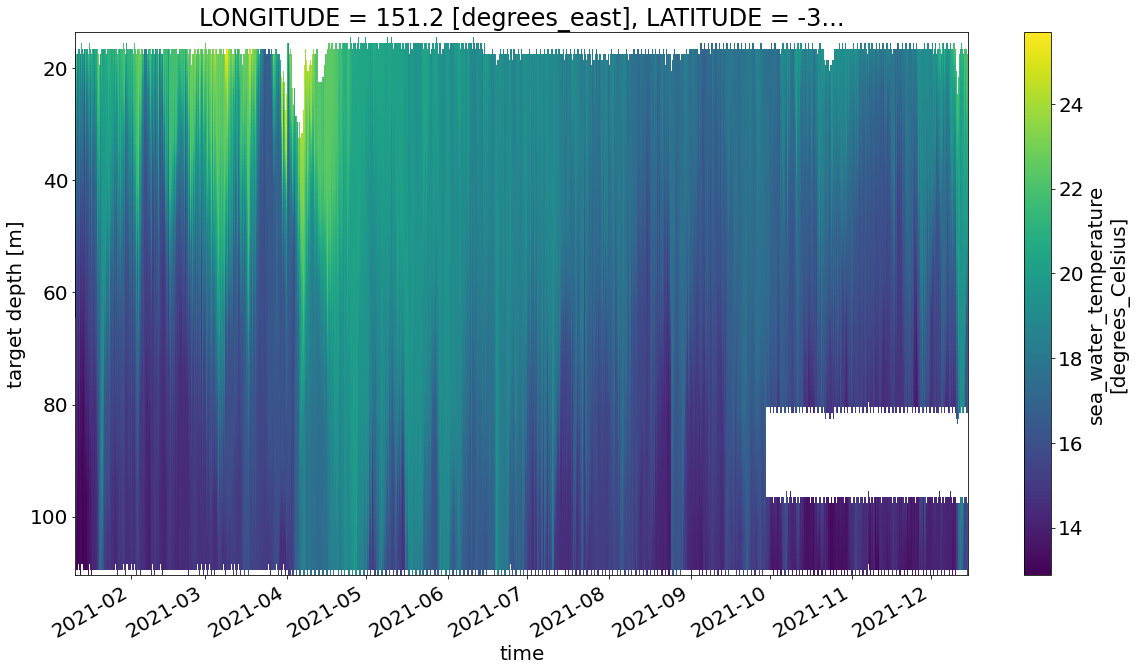

In [76]:
# %matplotlib qt
plt.figure(figsize=(20,10))
grd_data.TEMP.plot(x='TIME',y='DEPTH')
plt.gca().invert_yaxis()
plt.rc('font', size=20)
# %matplotlib inline

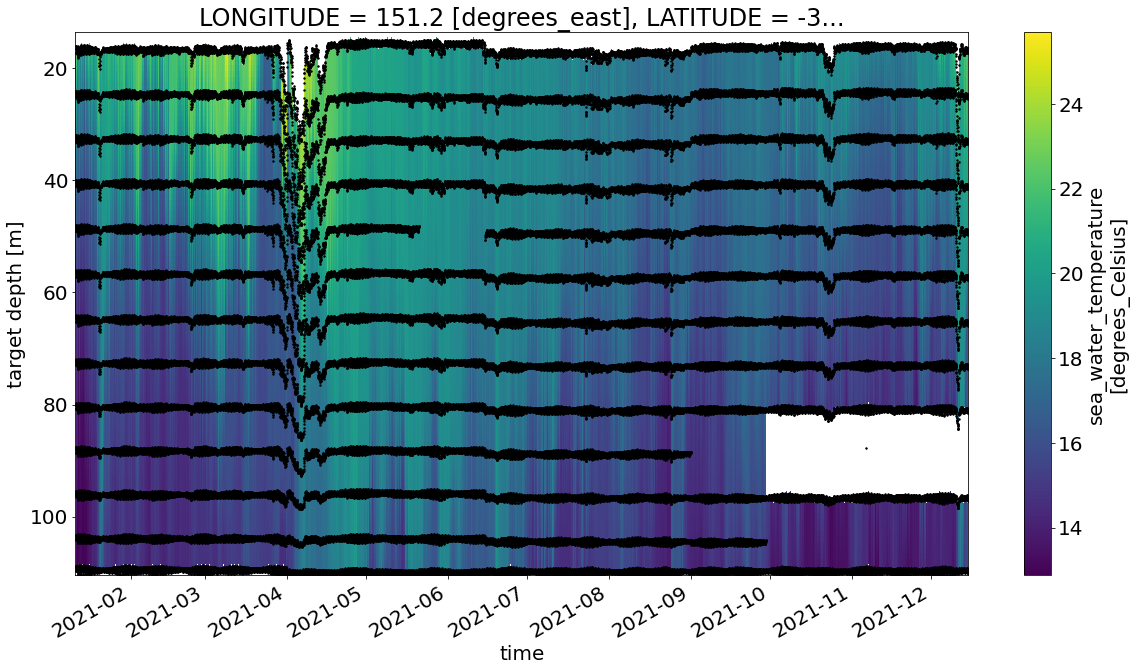

In [75]:
# %matplotlib qt
plt.figure(figsize=(20,10))
grd_data.TEMP.plot(x='TIME',y='DEPTH')
plt.scatter(hrly_data.TIME,hrly_data.DEPTH,c='k',s=2)
plt.gca().invert_yaxis()
plt.rc('font', size=20)
# %matplotlib inline

### Grid every e.g. 10 m instead

In [78]:
grid.grid_variable(hourly_file, 'TEMP', depth_bins=None, max_separation=50, depth_bins_increment=10,
                  input_dir='', output_dir='.', download_url_prefix=None, opendap_url_prefix=None)

PermissionError: [Errno 13] Permission denied: b'C:\\Users\\mphem\\Documents\\Work\\UNSW\\LTSP\\Code\\python-aodntools-master\\python-aodntools-master\\IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_TEMP-gridded-timeseries_END-20211215_C-20220428.nc'

In [ ]:
filename = 'IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_TEMP-gridded-timeseries_END-20211215_C-20220428.nc'
grd_data_10 = xr.open_dataset(filename)


# %matplotlib qt
plt.figure(figsize=(20,10))
grd_data_10.TEMP.plot(x='TIME',y='DEPTH')
plt.scatter(hrly_data.TIME,hrly_data.DEPTH,c='k',s=2)
plt.gca().invert_yaxis()
plt.rc('font', size=20)
# %matplotlib inline

![](slide_4.PNG) 